In [1]:
import json
import numpy as np
import os
from tqdm import tqdm

# Initialize containers for energies
methods = ["opt", "HF", "B3LYP", "sto-3G","basisNN"]
energy_data = {method: [] for method in methods}

# Load the JSON file
file_path = "inference.json"
with open(file_path, "r") as file:
    data = json.load(file)

eigenvalue_l = []
name_l = np.array(data["name"])
print(name_l)
print(len(data["proj"]))
for i in range(len(data["proj"])):
    # Extract the first matrix under the 'proj' key
    i_matrix = np.array(data["proj"][i])

    # Compute the eigenvalues
    eigenvalues = np.linalg.eigvals(i_matrix)
    eigenvalues.sort()
    eigenvalue_l.extend(eigenvalues)
print(len(eigenvalue_l))

['6.json' '2.json' '12.json' '16.json' '13.json' '22.json' '17.json'
 '7.json' '3.json' '11.json' '20.json' '9.json' '15.json' '19.json'
 '5.json' '1.json' '18.json' '4.json' '0.json' '10.json' '21.json'
 '8.json' '14.json']
23
460


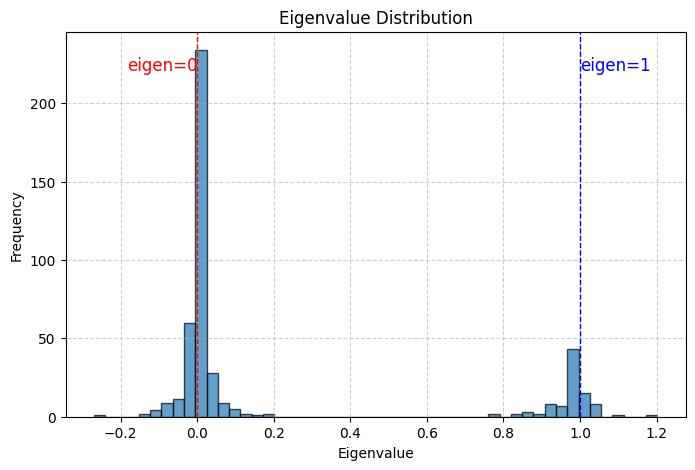

In [2]:
import matplotlib.pyplot as plt

def plot_distribution(eigenvalue_l, bins=50):
    plt.figure(figsize=(8, 5))
    plt.hist(eigenvalue_l, bins=bins, edgecolor='black', alpha=0.7)
    
    # Add vertical dashed lines
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.axvline(x=1, color='blue', linestyle='--', linewidth=1)
    
    # Add text labels
    plt.text(0, plt.ylim()[1] * 0.9, 'eigen=0', color='red', ha='right', fontsize=12)
    plt.text(1, plt.ylim()[1] * 0.9, 'eigen=1', color='blue', ha='left', fontsize=12)
    
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.title('Eigenvalue Distribution')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example usage
plot_distribution(eigenvalue_l)


In [3]:
from downfolding_methods_pytorch import nelec, norbs, fock_downfolding, Solve_fermionHam, perm_orca2pyscf
from pyscf import gto, scf, dft
import scipy

def calc_basisNN_inp_file(inp_data):
    elements = inp_data['elements']
    coordinates = inp_data['coordinates']
    atoms = [(elements[i], coordinates[i]) for i in range(len(elements))]
    S = gto.M(
        atom=atoms,  # Atomic symbols and coordinates
        basis="cc-pVDZ"
    ).intor("int1e_ovlp")
    sqrtS = scipy.linalg.sqrtm(S).real
    perm = perm_orca2pyscf(
        atom=atoms,  # Atomic symbols and coordinates
        basis="cc-pVDZ"
    )
    
    proj = inp_data['proj']
    proj = perm @ proj @ perm.T
    proj = sqrtS @ proj @ sqrtS
    
    n_fold = norbs(atom=atoms,basis='sto-3g')
    ham = fock_downfolding(n_fold,('self-defined',-proj),False,atom=atoms, basis='cc-pVDZ')
    E = Solve_fermionHam(ham.Ham_const, ham.int_1bd, ham.int_2bd, nele=nelec(atom=atoms, basis='sto-3G'), method='FCI')[0]
    return E

print(len(data["proj"]))


with tqdm(total=len(data["proj"]), desc="Processing", dynamic_ncols=True) as pbar:
    for proj, elements, pos in zip(data["proj"], data["elements"], data["pos"]):
        inp_data = {'elements': elements, 'coordinates': pos, 'proj': proj}
        basisNN_E = calc_basisNN_inp_file(inp_data)
        energy_data['basisNN'].append(basisNN_E)
        
        pbar.set_postfix({"basisNN_E": f"{basisNN_E:.6f}"})  # Format to 6 decimals for better readability
        pbar.update(1)

23


Processing: 100%|██████████| 23/23 [00:13<00:00,  1.76it/s, basisNN_E=-2.017263]


In [4]:
folder = "/home/hewenhao/Documents/wenhaohe/research/learn_basis/learn_basis/dataset/H4_074_test"
# collect other energies
for name in name_l:
    # Load the JSON file
    file_path = os.path.join(folder,'obs',name)
    with open(file_path, "r") as file:
        data = json.load(file)
    energy_data['opt'].append(data['opt_E'])
    energy_data['HF'].append(data['HF_E'])
    energy_data['B3LYP'].append(data['B3LYP_E'])
    energy_data['sto-3G'].append(data['sto-3G_E'])


FileNotFoundError: [Errno 2] No such file or directory: '/home/hewenhao/Documents/wenhaohe/research/learn_basis/learn_basis/dataset/H4_test/obs/6.json'

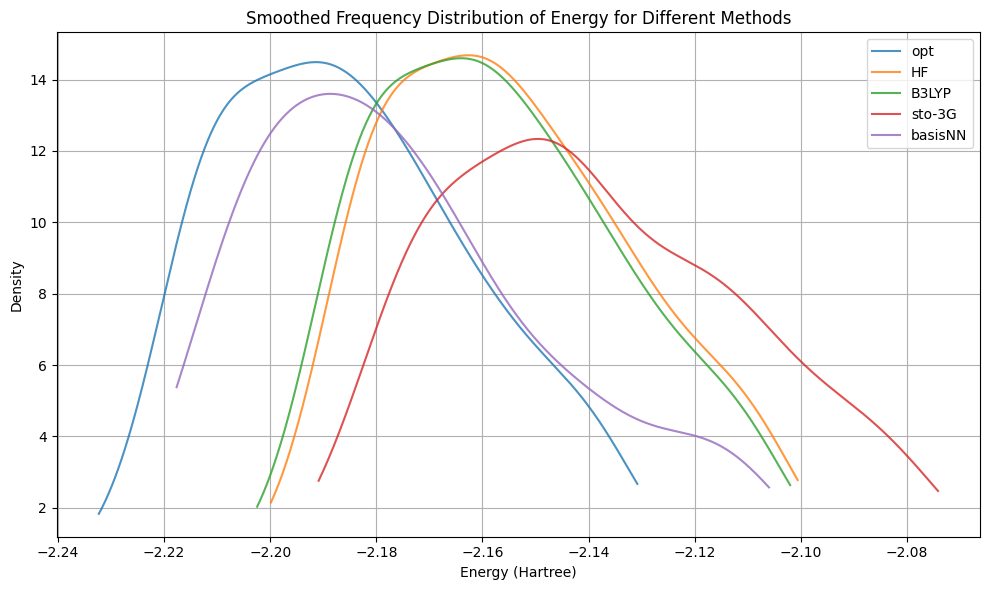

Figure saved as energy_distribution_smooth.png


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Plot the frequency distribution for each method using KDE
plt.figure(figsize=(10, 6))

for method in methods:
    if energy_data[method]:  # Ensure there's data to plot
        # Perform Kernel Density Estimation
        data = np.array(energy_data[method])
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 500)  # Generate x-axis values
        y_vals = kde(x_vals)  # Evaluate KDE for the x-axis values

        # Plot the KDE curve
        plt.plot(x_vals, y_vals, label=method, linewidth=1.5, alpha=0.8)

# Configure the plot
plt.title("Smoothed Frequency Distribution of Energy for Different Methods")
plt.xlabel("Energy (Hartree)")
plt.ylabel("Density")
plt.legend(loc="best")
plt.grid(True)

# Save the plot as a file
output_file = "energy_distribution_smooth.png"
plt.tight_layout()
#plt.savefig(output_file, dpi=300)
plt.show()
plt.close()

print(f"Figure saved as {output_file}")